In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
struct OneHotTestLoader
    loader::DataLoader
    n_classes::Int
end

function Base.iterate(loader::OneHotTestLoader)
    state = iterate(loader.loader)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

function Base.iterate(loader::OneHotTestLoader, loader_state)
    state = iterate(loader.loader, loader_state)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

Base.length(loader::OneHotTestLoader) = length(loader.loader)

test_loader_onehot = OneHotTestLoader(test_loader, 10)

OneHotTestLoader(DataLoader(::FashionMNIST, batchsize=128), 10)

In [14]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [15]:
x0 |> size

(28, 28, 128)

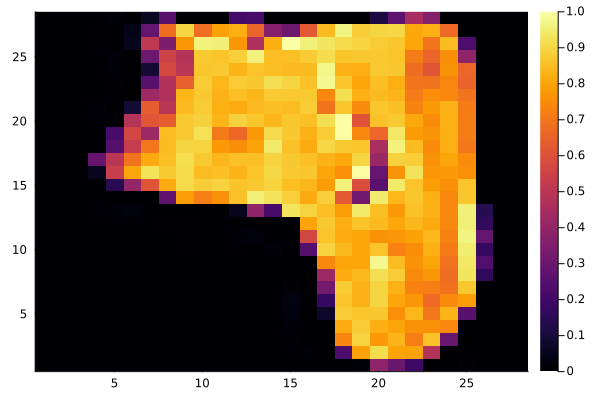

In [16]:
heatmap(x0[:,:,1])

# Test Phasor network

In [17]:
import .PhasorNetworks: default_bias

In [18]:
vsa_layer = 32

32

In [19]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => vsa_layer, soft_angle, init_bias=default_bias),
            Codebook(vsa_layer => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#31),
    layer_4 = WrappedFunction(#32),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 32, use_bias=false),  # 4_096 parameters
        bias = ComplexBias((32,)),                # 64 parameters
    ),
    layer_7 = Codebook(32 => 10),
)         # Total: 106_336 parameters,
          #        plus 320 states.

In [20]:
i_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => vsa_layer, soft_angle, init_bias=default_bias),
            x -> x
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#35),
    layer_4 = WrappedFunction(#36),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 32, use_bias=false),  # 4_096 parameters
        bias = ComplexBias((32,)),                # 64 parameters
    ),
    layer_7 = WrappedFunction(#37),
)         # Total: 106_336 parameters,
          #        plus 0 states.

In [21]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.0056312787 0.04889111 … -0.05050768 0.045184698; -0.040384673 0.033313625 … 0.04332045 -0.045717828; … ; 0.044033002 -0.055932578 … -0.007478507 -0.046164002; 0.024524597 -0.038179252 … 0.0029826495 0.0011508339],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[0.0980228 -0.112927295 … 0.099765204 -0.06487079; -0.023803396 -0.07354423 … -0.04398847 0.122056484; … ; -0.04436694 0.0121455835 … -0.04588809 -0.10667842; 0.14846596 0.01656392 … -0.030736854 -0.014866476],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [22]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.046086155 0.076284826 … 0.099605486 0.10337705; 0.0044109486 -0.043856613 … -0.16627157 0.032334052; … ; 0.1582529 0.1405503 … 0.16080974 0.20941326; 0.06104791 0.057239965 … 0.19613507 0.121493086], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = (codes = Float32[0.73894274 -0.88003933 … 0.108068824 0.19011855; 0.106315136 0.9745741 … -0.52342737 0.42324972; … ; 0.9723028 0.16144669 … 0.5726905 -0.9277966; -0.041530013 -0.32847726 … 0.25916433 -0.333395],)))

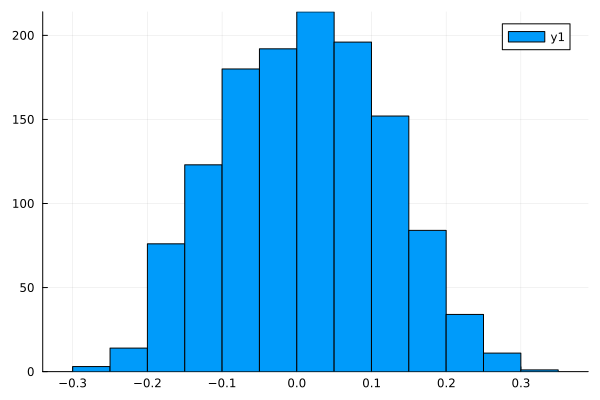

In [23]:
histogram(cdev(vec(yp0)))

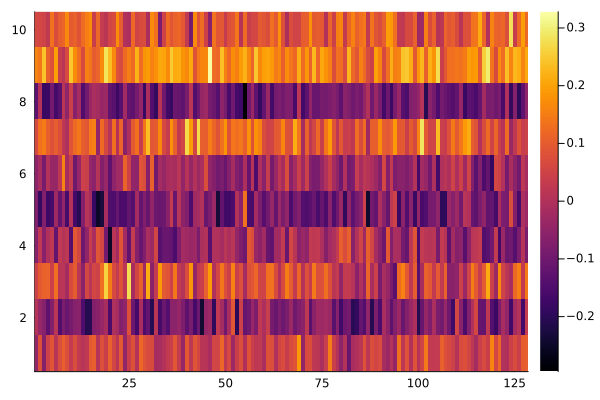

In [24]:
heatmap(cdev(yp0))

In [25]:
size(yp0)

(10, 128)

In [26]:
sh0, st1 = p_model(x0 |> gdev, psp, stp);

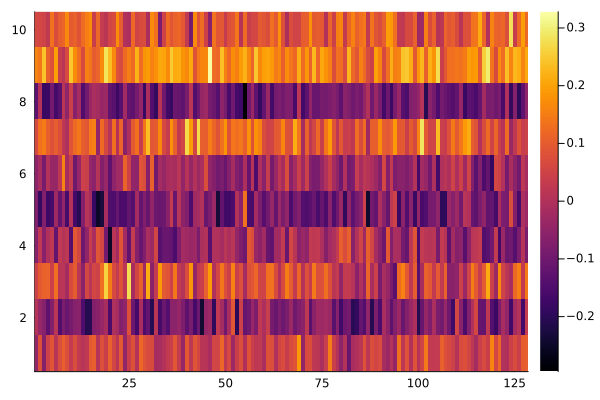

In [27]:
heatmap(cdev(sh0))

In [28]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = evaluate_loss(y_pred, y_onehot, :similarity) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [29]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.9627817264718588

In [30]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


(Any[0.9627817276597346, 0.8386300172519539, 0.777297891429203, 0.7407906694993446, 0.6936264462793986, 0.6373477289655192, 0.6232574675925794, 0.6047677030541474, 0.6041198602325375, 0.5765041020224912  …  0.0656323248828012, 0.05883321648294308, 0.04205347905331834, 0.08018906522243695, 0.0671124224495998, 0.0543823242791238, 0.08258232540691378, 0.07809332714276823, 0.045071325553878355, 0.0534223518812618], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[-0.17705218; 0.045247417; … ; 0.18148832; 0.040083725;;], scale = Float32[1.1538899; 0.9405006; … ; 0.8217883; 0.9417605;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.028918572 0.040408954 … -0.051055223 0.029982444; -0.03609692 0.008603208 … -0.00027197742 -0.062321287; … ; 0.023841407 -0.060130853 … 0.01561053 -0.0532479; -0.00871902 -0.06525418 … -0.012915268 -0.02162904],), bias = (bias_real = Float32[0.9972269, 0.9880187, 1.2610849, 0.98965853, 1.0885265, 1.0882653, 1.0384833, 

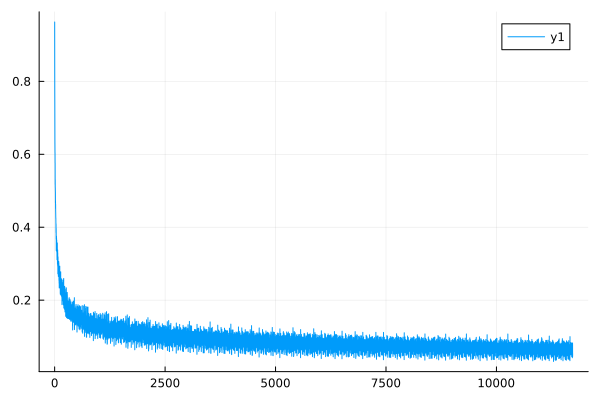

In [31]:
plot(losses_f)

In [32]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[0.17461315 0.9649321 … 0.11771627 0.5386787; -0.057777584 0.005432673 … -0.09123695 -0.099319465; … ; -0.048535436 0.054893054 … -0.013282351 0.09991475; 0.9553345 0.2423787 … -0.08030035 0.25950933], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = (codes = Float32[0.73894274 -0.88003933 … 0.108068824 0.19011855; 0.106315136 0.9745741 … -0.52342737 0.42324972; … ; 0.9723028 0.16144669 … 0.5726905 -0.9277966; -0.041530013 -0.32847726 … 0.25916433 -0.333395],)))

In [33]:
size(yp1)

(10, 128)

In [34]:
yp1

10×128 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.174613     0.964932     0.576552   …   0.128363    0.117716     0.538679
 -0.0577776    0.00543267   0.13567        0.115877   -0.0912369   -0.0993195
 -0.337596     0.080957    -0.0796033      0.85242     0.00187584  -0.209749
  0.300571     0.0424874    0.618691      -0.178802    0.106971     0.364841
  0.25529     -0.1569      -0.102796      -0.11877    -0.0255546   -0.103328
 -0.00555339   0.0141002    0.0708915  …  -0.0888383   0.290255     0.0691134
 -0.243518    -0.136315     0.132759       0.066266   -0.158848     0.34038
  0.030969     0.094934     0.0128968     -0.127793    0.883678     0.187164
 -0.0485354    0.0548931   -0.0607142      0.152393   -0.0132824    0.0999148
  0.955334     0.242379     0.300303      -0.253243   -0.0803004    0.259509

In [35]:
i0, _ = i_model(x0, ps_train_f |> cdev, st_train_f |> cdev) 

(Float32[0.21753752 0.82037276 … 0.89143634 0.7385997; 0.60765964 0.07110931 … -0.39420903 0.22649352; … ; 0.9189965 -0.9791403 … 0.39137617 0.5842031; -0.2398965 -0.0782452 … 0.32466605 -0.2615225], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = (codes = Float32[0.73894274 -0.88003933 … 0.108068824 0.19011855; 0.106315136 0.9745741 … -0.52342737 0.42324972; … ; 0.9723028 0.16144669 … 0.5726905 -0.9277966; -0.041530013 -0.32847726 … 0.25916433 -0.333395],)))

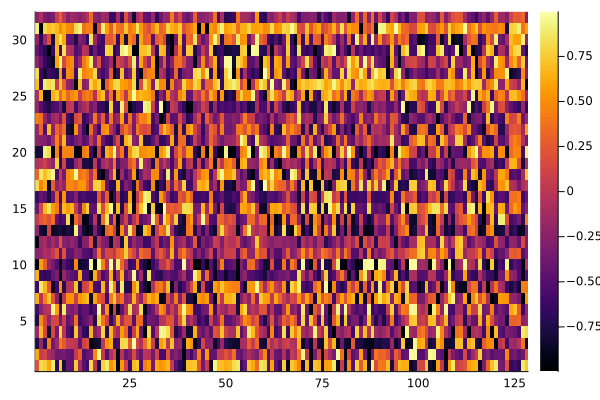

In [36]:
heatmap(i0)

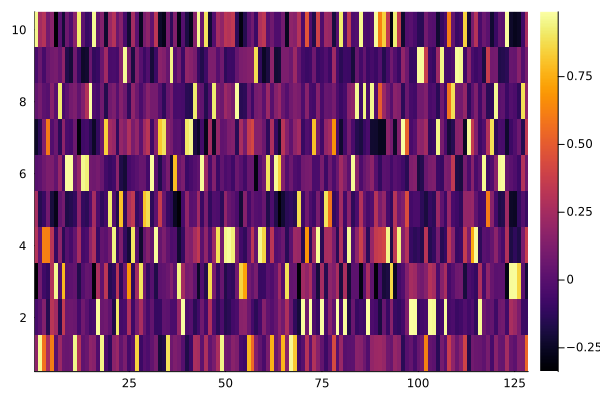

In [37]:
heatmap(cdev(yp1))

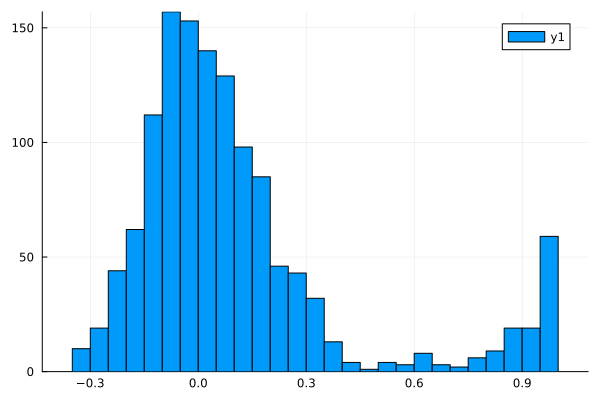

In [38]:
histogram(vec(cdev(yp1)))

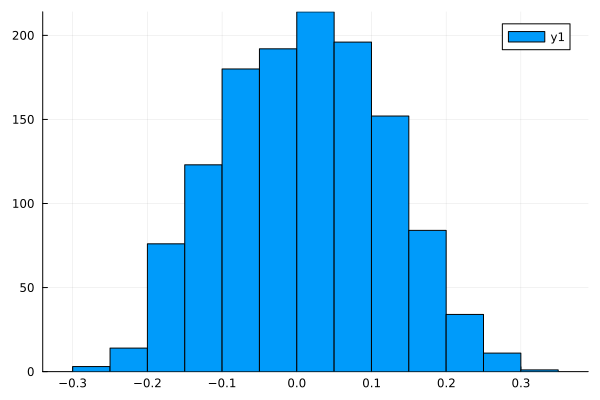

In [39]:
histogram(cdev(vec(yp0)))

In [40]:
x, y = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [41]:
xt, yt = first(test_loader_onehot) .|> gdev;

In [127]:
evaluate_loss(p_model(xt, ps_train_f, st_train_f)[1], onehotbatch(y, 0:9) |> gdev, :similarity)

1×128 CuArray{Float64, 2, CUDA.DeviceMemory}:
 0.032569  0.00248762  0.0002218  …  0.00194572  0.0138574  0.475187

In [42]:
evaluate_loss(p_model(xt, ps_train_f, st_train_f)[1], onehotbatch(y, 0:9) |> gdev, :similarity) |> mean

0.0934166359879133

In [43]:
evaluate_accuracy(p_model(xt, ps_train_f, st_train_f)[1], onehotbatch(y, 0:9) |> gdev, :similarity) 

([115], 128)

In [44]:
aa =p_model(xt, ps_train_f, st_train_f)[1]

10×128 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.254254    0.0334523    0.0308826  …   0.96028    -0.0117646  -0.0159265
 -0.0127663   0.233525     0.986591      -0.0151099   0.0178559  -0.022488
 -0.284673    0.955086     0.247699       0.051895    0.120947    0.437455
  0.371657   -0.132799    -0.135243      -0.0113497  -0.12586    -0.0569874
  0.130906   -0.156656    -0.0703242     -0.161313   -0.229976    0.351729
  0.211285   -0.00205267   0.0934185  …   0.042445   -0.107472   -0.0957587
 -0.203014    0.0837242   -0.0533024      0.021991    0.249977    0.513885
  0.201467    0.0155322   -0.0618068      0.0586433  -0.0299533  -0.120606
 -0.20244     0.0555401   -0.0616016      0.0658583   0.893894    0.122826
  0.837077   -0.283448    -0.0270825      0.129011   -0.202411   -0.2022

In [45]:
truth = yt
reduce_dim = 1
reshape_dims = [d == reduce_dim ? 1 : size(truth,d) for d in 1:ndims(truth)]

2-element Vector{Int64}:
   1
 128

In [46]:
getindex.(findall(truth .== 1.0f0), reduce_dim)

128-element CuArray{Int64, 1, CUDA.DeviceMemory}:
 10
  3
  2
  2
  7
  2
  5
  7
  6
  8
  5
  6
  8
  ⋮
  9
  7
  8
  9
  1
  1
 10
 10
  4
  1
  9
  5

In [47]:
predict(yp1, :codebook, reduce_dim=reduce_dim)

128-element Vector{Int64}:
 10
  1
  4
  4
  1
  3
  8
  3
  6
  6
  1
 10
  6
  ⋮
  6
  5
  7
  8
  6
  6
 10
  3
  3
  3
  8
  1

In [48]:
yt

10×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅

In [49]:
loss_and_accuracy(test_loader_onehot, p_model, ps_train_f, st_train_f, args; encoding = :similarity)

(0.09695109773237036, 0.8729)

# Test spiking behavior

In [54]:
import .PhasorNetworks: Codebook, LuxParams

In [55]:
spk_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            Codebook(16 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#43),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = Codebook(16 => 10),
)         # Total: 104_256 parameters,
          #        plus 160 states.

In [56]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.0135705015 -0.05729247 … 0.0163186 -0.017677143; -0.0026602584 0.060192093 … 0.051260214 -0.022274366; … ; -0.023816729 -0.012598705 … 0.053770266 0.045829695; -0.053956818 -0.0069056815 … 0.008795149 -0.054133724],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[-0.14734356 -0.11203233 … -0.10271278 -0.09439357; -0.051993318 -0.111854024 … -0.08929189 0.04747729; … ; -0.074096166 -0.09537681 … 0.05314868 0.041080713; -0.09813437 -0.06701051 … -0.13512348 0.019357903],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [57]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.49999997 -0.49999997 … -0.49999997 -0.49999997; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.49999997 -0.49999997 … -0.49999997 -0.49999997; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5

In [58]:
ys0 |> size

(2001,)

In [59]:
typeof(ys0)

Vector{CuArray{Float32, 2, DeviceMemory}} (alias for Array{CuArray{Float32, 2, CUDA.DeviceMemory}, 1})

In [60]:
typeof(ys0) <: AbstractVector{<:AbstractArray}

true

In [62]:
ys0s = stack(ys0)

10×128×2001 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  …  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5     -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5

In [63]:
predict(ys0s, :similarity, reduce_dim=1)

128×2001 Matrix{Int64}:
 1  7  1  1  1  1  2  1  2  1  1  6  1  …   4   4   4   4   4   4   4   4   4
 1  7  1  1  1  1  2  1  2  1  1  6  1      1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1      1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1      1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1      1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1  …  10  10  10  10  10  10  10  10  10
 1  7  1  1  1  1  2  1  2  1  1  6  1      1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1      4   4   4   4   4   4   4   4   4
 1  7  1  1  1  1  2  1  2  1  1  6  1      8   8   8   8   8   8   8   8   8
 1  7  1  1  1  1  2  1  2  1  1  6  1      1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1  …   1   1   1   1   1   1   1   1   1
 1  7  1  1  1  1  2  1  2  1  1  6  1      6   6   6   6   6   6   6   6   6
 1  7  1  1  1  1  2  1  2  1  1  6  1  

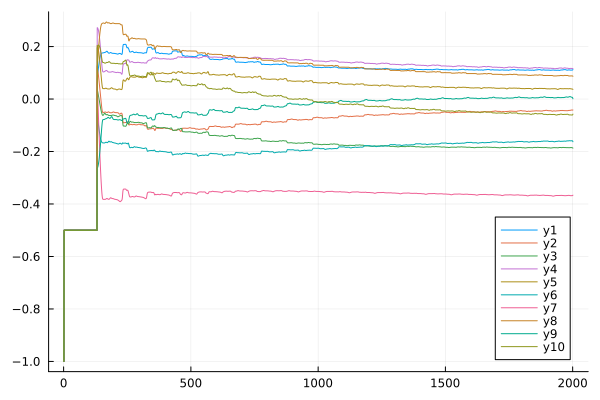

In [64]:
plot(ys0s[:,1,:]' |> cdev)

In [65]:
yp0 |> size

(10, 128)

In [66]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5

In [67]:
y_spk_s = y_spk_f |> stack |> cdev;

In [68]:
size(y_spk_s)

(10, 128, 2001)

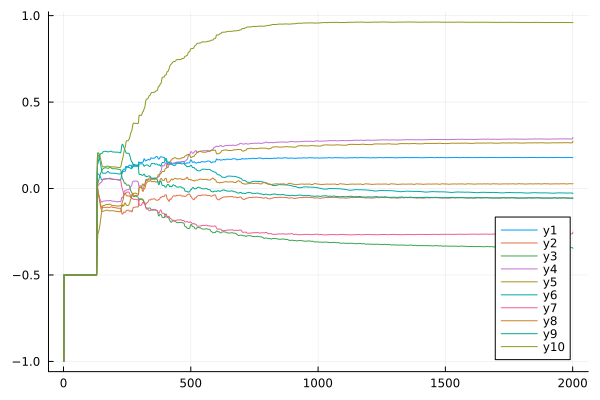

In [69]:
plot(y_spk_s[:,1,:]')

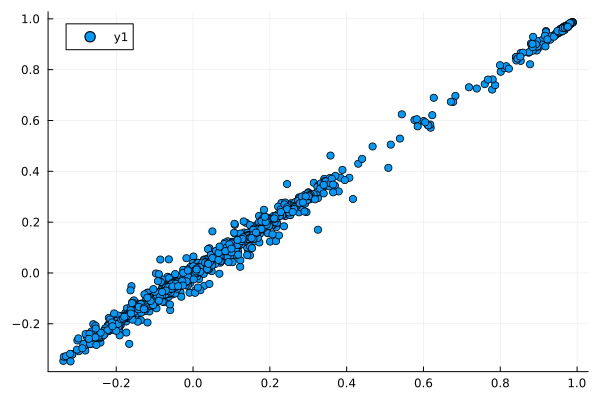

In [70]:
scatter(vec(cdev(yp1)), vec(y_spk_s[:,:,end]))

In [71]:
spk_inner = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            x -> x,
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#45),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = WrappedFunction(#46),
)         # Total: 104_256 parameters,
          #        plus 0 states.

In [72]:
y_spk_i, _ = spk_inner(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(23, 128), CartesianIndex(24, 128), CartesianIndex(25, 128), CartesianIndex(26, 128), CartesianIndex(27, 128), CartesianIndex(28, 128), CartesianIndex(29, 128), CartesianIndex(30, 128), CartesianIndex(31, 128), CartesianIndex(32, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096], Float32[2.019271, 1.9949281, 2.0006645, 2.0044653, 2.0076141, 2.0035555, 2.0010612, 2.008792, 2.001691, 2.0017765  …  20.99302, 20.50805, 21.498148, 21.00999, 20.695152, 21.070236, 20.991924, 20.654854, 20.502796, 21.476612], (32, 128), 4096, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple

In [118]:
_, yh0 = first(test_loader_onehot)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 1 0 … 0 0])

In [121]:
lvs = evaluate_loss(y_spk_f, yh0 |> gdev, :similarity)

2001-element Vector{CuArray{Float64, 2, CUDA.DeviceMemory}}:
 [1.999999999999996 1.999999999999996 … 1.999999999999996 1.999999999999996]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071067944474196]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.70710682

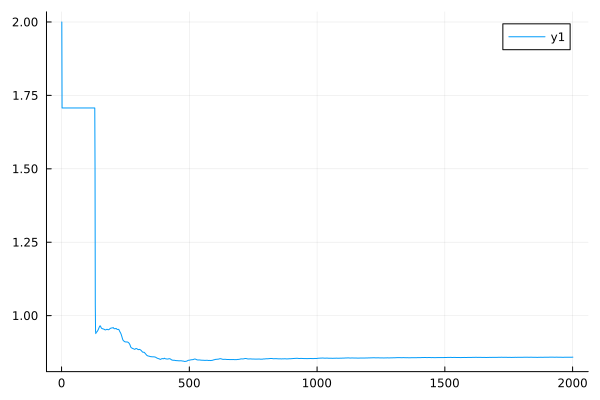

In [137]:
plot(sum.(lvs) ./ 128)

In [125]:
stack(lvs)

1×128×2001 CuArray{Float64, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0

[:, :, 2] =
 1.70711  1.70711  1.70711  1.70711  …  1.70711  1.70711  1.70711  1.70711

[:, :, 3] =
 1.70711  1.70711  1.70711  1.70711  …  1.70711  1.70711  1.70711  1.70711

;;; … 

[:, :, 1999] =
 0.00197111  0.864908  0.757472  …  1.2022  0.798798  0.978583  1.10039

[:, :, 2000] =
 0.00198741  0.864317  0.757989  …  1.20587  0.7963  0.98029  1.10042

[:, :, 2001] =
 0.00206732  0.863393  0.758516  1.2091  …  0.791484  0.984667  1.09957

In [73]:
length(test_loader) * 70 / 60

92.16666666666667

In [74]:
st3 = get_time(y_spk_i.train, (5.0, 10.0))

Spike Train: (32, 128) with 20483 spikes.

In [75]:
st3_b1 = st3[:,1:5]

Spike Train: (32, 5) with 801 spikes.

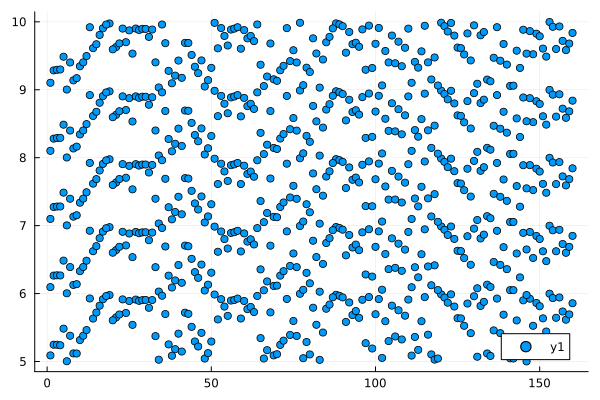

In [76]:
scatter(LinearIndices(st3_b1.shape)[st3_b1.indices], st3_b1.times) 

In [88]:
test_batch = (first(test_loader_onehot),)

((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 1 0 … 0 0]),)

In [85]:
import .PhasorNetworks: spiking_loss_and_accuracy, on_gpu

In [147]:
function spiking_loss_and_accuracy(data_loader, model, ps, st, args; reduce_dim::Int=1, encoding::Symbol = :codebook)
    loss_fn = (x, y) -> evaluate_loss(x, y, encoding, reduce_dim=reduce_dim) .|> cdev

    if args.use_cuda && CUDA.functional()
        dev = gdev
    else
        dev = cdev
    end

    num = 0
    correct = []
    ls = []

    for (x, y) in data_loader
        x = x |> dev
        y = y |> dev
        ŷ, _ = model(x, ps, st)
        loss_vals = sum.(zero_nans.(loss_fn(ŷ, y)))
        append!(ls, [loss_vals,])
        model_correct, answers = cdev.(evaluate_accuracy(ŷ, y, encoding, reduce_dim=reduce_dim))
        append!(correct, model_correct)
        num += answers
    end

    correct = stack(correct) ./ num
    ls = stack(ls) ./ num
    return ls, correct
end

spiking_loss_and_accuracy (generic function with 1 method)

In [148]:
spk_l, spk_a = spiking_loss_and_accuracy(test_batch, spk_model, ps_train_f, st_train_f, args)

([1.9999999999999947; 1.7071068244461578; … ; 0.09110744473981168; 0.09094211137139349;;], [0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.0859375, 0.09375, 0.09375, 0.09375, 0.09375  …  0.8828125, 0.8828125, 0.8828125, 0.8828125, 0.8828125, 0.8828125, 0.8828125, 0.8828125, 0.8828125, 0.875])

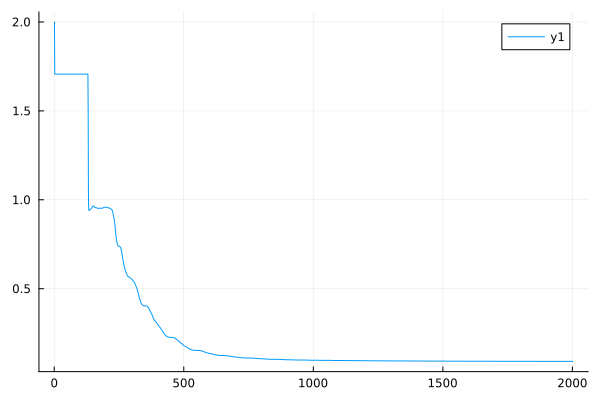

In [149]:
plot(spk_l)

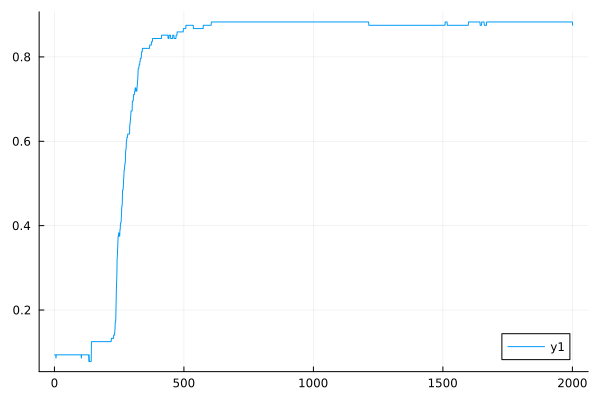

In [150]:
plot(spk_a)

In [106]:
lvs = stack([rand(Float32, 40, 128), rand(Float32, 40, 128)])

40×128×2 Array{Float32, 3}:
[:, :, 1] =
 0.601516   0.142424   0.731353   …  0.542811   0.163585   0.20306
 0.66468    0.072188   0.254992      0.0528648  0.898107   0.155143
 0.189662   0.610814   0.866775      0.570393   0.829794   0.482004
 0.826166   0.893716   0.824765      0.0719309  0.673538   0.241071
 0.688092   0.791917   0.578427      0.722274   0.110523   0.0389475
 0.769653   0.298153   0.428022   …  0.581197   0.422234   0.336175
 0.140579   0.461738   0.480346      0.168032   0.985323   0.025526
 0.25183    0.11222    0.212412      0.683883   0.54513    0.954009
 0.176003   0.797732   0.213763      0.21166    0.327209   0.466407
 0.910446   0.282606   0.221983      0.0728749  0.0345732  0.824505
 0.806298   0.587126   0.912992   …  0.771963   0.850523   0.0375131
 0.0709515  0.248427   0.604646      0.0929906  0.409718   0.605349
 0.533967   0.0205509  0.956124      0.641889   0.936206   0.599637
 ⋮                                ⋱  ⋮                     
 0.924972   0.2

In [102]:
spk_l |> size

(1, 128, 2001, 1)

In [94]:
spk_a |> size

(2001,)

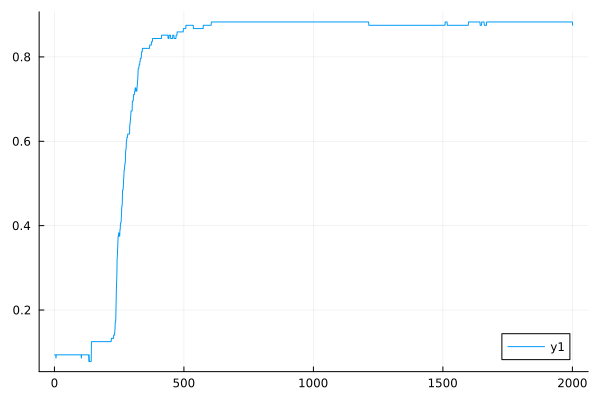

In [97]:
plot(spk_a ./ 128)

In [ ]:
spk_l, spk_a = spiking_loss_and_accuracy(test_loader_onehot, spk_model, ps_train_f, st_train_f, args, repeats=)

LoadError: type SpikingArgs has no field repeats

# Test conventional network

In [ ]:
construct_model = n -> Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => n, relu),
            Dense(n => 10),
            softmax)

#31 (generic function with 1 method)

In [ ]:
model = construct_model(128)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),            # 100_480 parameters
    layer_4 = Dense(128 => 10),                   # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [ ]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.0112625575 0.09778222 … -0.10101536 0.090369396; -0.080769345 0.06662725 … 0.0866409 -0.091435656; … ; 0.088066004 -0.111865155 … -0.014957014 -0.092328005; 0.049049195 -0.076358505 … 0.005965299 0.0023016678], bias = Float32[0.022867223, -0.005552969, 0.0128062535, 0.016987672, -0.029769417, -0.028511818, -0.034402616, -0.012781019, 0.005802878, 0.033536788  …  0.025755508, 0.0049556494, 0.01800868, -0.015800416, 0.009187677, 0.0042766673, 0.011223478, 0.0118460525, 0.019908717, -0.0135502685]), layer_4 = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327], bias = Float32[-0.031575713, -0.087607525, -0.0455442, 0.051857945, 0.047413476, 0.079458684, 0.08564899, -

In [ ]:
yp, _ = model(x0, ps, st);

In [ ]:
yp |> size

(10, 128)

In [ ]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [ ]:
loss_function(x0, y0, model, ps, st)

2.8641567f0

In [ ]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CPU


(Any[2.8641567f0, 2.5659437f0, 2.387064f0, 2.1986299f0, 2.148335f0, 1.8518924f0, 1.7919455f0, 1.6326872f0, 1.6997683f0, 1.5456713f0  …  0.20519409f0, 0.18482399f0, 0.14162587f0, 0.23544107f0, 0.24074218f0, 0.16624248f0, 0.22450583f0, 0.22559026f0, 0.09765837f0, 0.15866928f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.038406536; 0.017918281; … ; 0.046671223; 0.019242242;;], scale = Float32[0.969162; 0.9840778; … ; 0.9716084; 0.98476076;;]), layer_3 = (weight = Float32[0.0062826984 0.11479646 … -0.08033957 0.10508532; -0.08677065 0.059964977 … 0.0745905 -0.092425995; … ; 0.073537506 -0.12590684 … -0.03909918 -0.11069321; 0.07812478 -0.0465651 … 0.033894457 0.032850184], bias = Float32[0.006977855, 0.0047661057, -0.0036222101, 0.012951335, -0.0019997153, -0.013606623, 0.023555515, 0.011161522, 0.044679105, 0.011207561  …  -0.005677891, -0.011133213, 0.0023209886, 0.019759463, 0.01545383, 0.04544099, 0.01437314, -0.0002253647, 0.03578561, -0.04288651]), layer_4 = (weight = Float

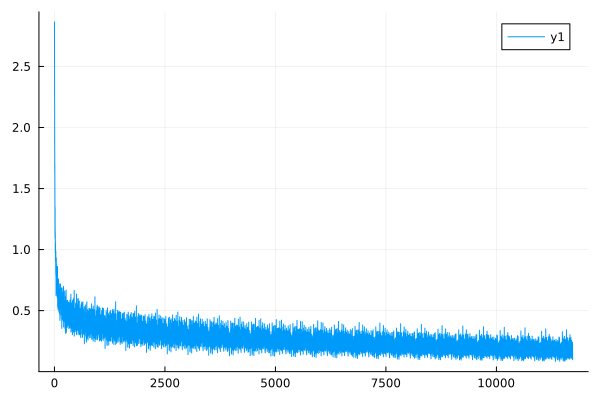

In [ ]:
plot(losses)

In [ ]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [ ]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [ ]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0821

In [ ]:
test(model, test_loader, pst, stt)

0.8824

In [ ]:
function automate_train(n::Integer, e::Integer)
    args = Args(batchsize = 128, epochs = e, use_cuda = true)
    model = construct_model(n)
    ps, st = Lux.setup(args.rng, model)
    losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)
    final_loss = losses[end]
    accuracy = test(model, test_loader, pst, stt)

    return accuracy, final_loss
end

automate_train (generic function with 1 method)

In [ ]:
#automate_train(64, 5)